In [2]:
import scanpy as sc
import anndata as ad
import pandas as pd
import gzip

sc.settings.set_figure_params(dpi=50, facecolor="white")

samples = ["blood_12w_KO_01", "blood_12w_KO_02", "blood_12w_WT_01", "blood_12w_WT_02", "blood_ss_KO_B6", "blood_ss_WT_B6"]

def get_dir(sample_name):

    return f"C:/Users/Hew/OneDrive/Documents/_PhD - Oxford/Training/Bioinformatics/mm_blood_10x/{sample_name}/mtx"

#data = {}

#for sample in samples:
#    data[sample] = sc.read_10x_mtx(get_dir(sample), make_unique = True)

adata = sc.read_10x_mtx(get_dir("blood_12w_KO_01"), make_unique = True)
#adata = ad.concat(data, label="sample")
adata.obs_names_make_unique()

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.startswith("Hb")

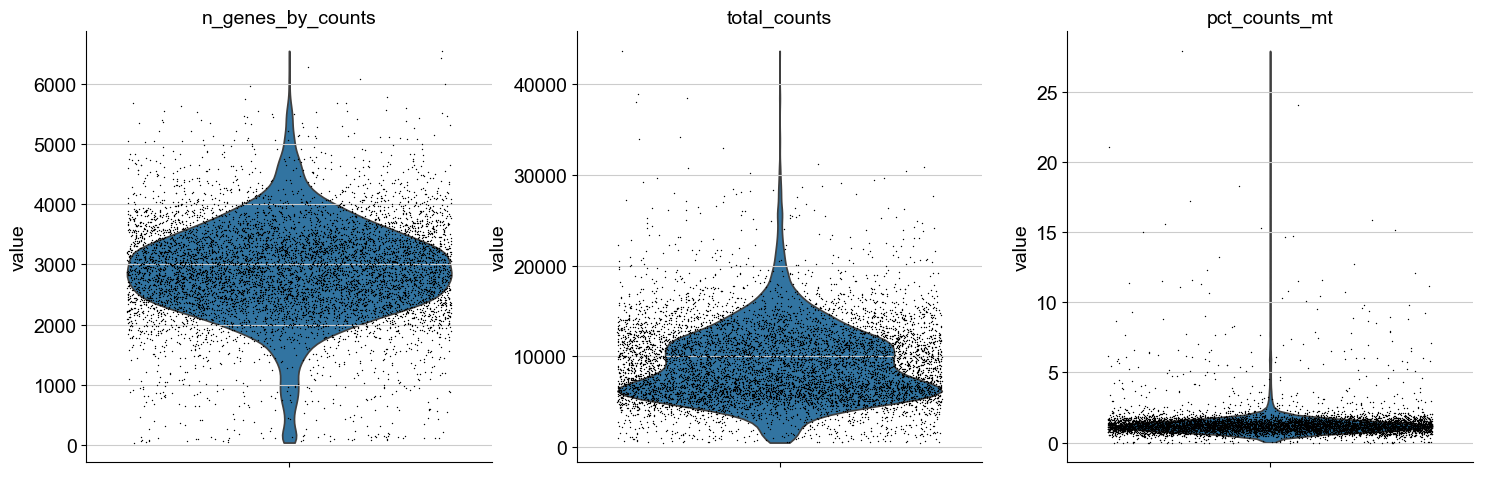

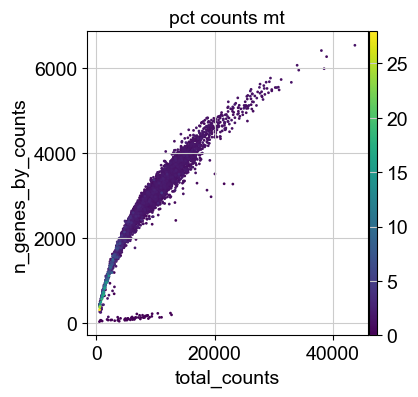

In [3]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

c:\Users\Hew\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


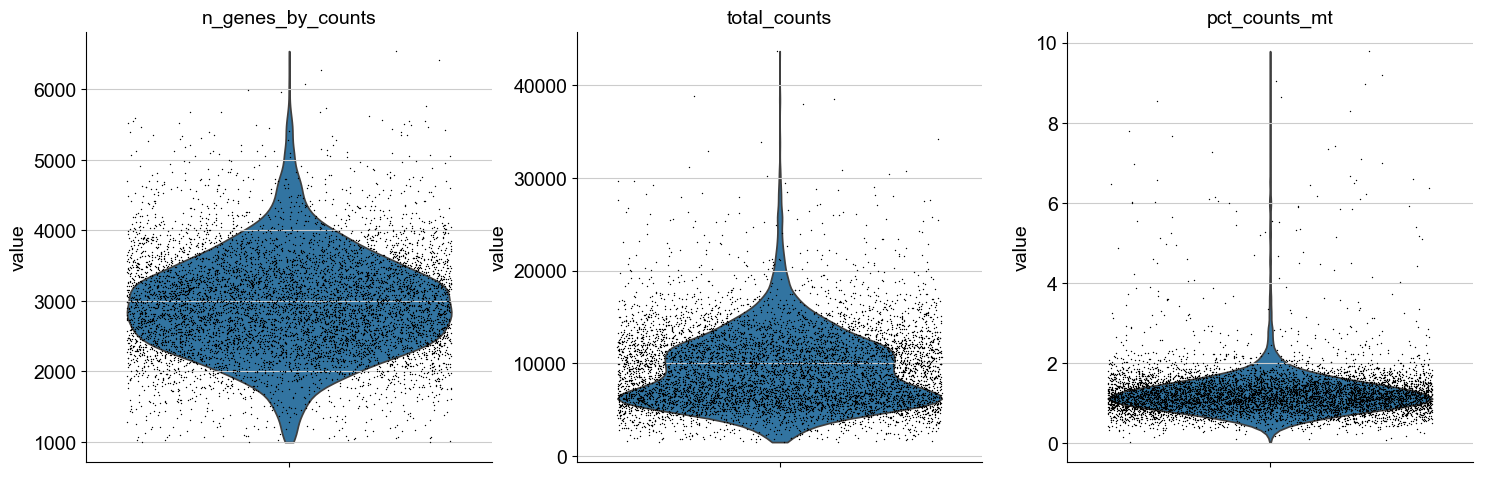

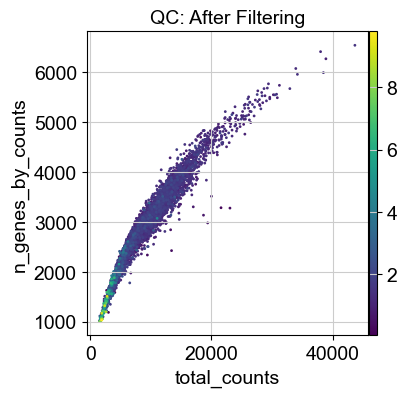

Number of cells filtered = 184
Number of genes filtered = 15761
(7511, 16524)


In [4]:
# FILTER GENES
# 5-10% mitochondrial gene counts is normal

prev_cell_count = adata.n_obs
prev_gene_count = adata.n_vars

#Filter based on total genes by count
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=5)

# Further filter out cells with >10% mitochondrial gene content, and total counts more than 6500
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
adata = adata[adata.obs.n_genes_by_counts < 10000, :]

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt", title="QC: After Filtering")


# Print the number of cells and genes after filtering
print(f"Number of cells filtered = {prev_cell_count - adata.n_obs}")
print(f"Number of genes filtered = {prev_gene_count - adata.n_vars}")

print(adata.shape)

In [5]:
# DOUBLETS

adata.obs["sample"] = "blood_12w_WT_01"

sc.pp.scrublet(adata, batch_key="sample")

print("Number of doublets predicted = ", len(adata.obs[adata.obs['predicted_doublet'] == True]))
doublets = adata.obs[adata.obs['predicted_doublet'] == True].index
print("Doublets = ", doublets)

# remove from data
adata = adata[~adata.obs.index.isin(doublets)]



Number of doublets predicted =  120
Doublets =  Index(['AACCCAATCAAAGGAT-1', 'AACCTTTGTATCGCGC-1', 'AAGCATCGTCGAGCTC-1',
       'AAGCCATGTTAGCTAC-1', 'AATTTCCCATGTTACG-1', 'ACAAAGAGTCGAAACG-1',
       'ACAGAAAAGGTCACCC-1', 'ACGATCATCCATTTAC-1', 'ACGGAAGCAGACAAAT-1',
       'ACTACGAGTGACTAAA-1',
       ...
       'TTACGCCCAGCAGTCC-1', 'TTACGTTTCTTCGTAT-1', 'TTATTGCGTTGCTCAA-1',
       'TTCACCGGTACGCGTC-1', 'TTCCACGGTGAAAGTT-1', 'TTCCTTCGTGCGGATA-1',
       'TTGAGTGCACCGGAAA-1', 'TTGCGTCTCCAAGCTA-1', 'TTTACCACAGCTGAAG-1',
       'TTTAGTCTCATGCCGG-1'],
      dtype='object', length=120)


In [6]:
# NORMALISATION

adata.layers["counts"] = adata.X.copy() #copies raw count matrix into a new layer "counts", so raw data is preserved

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

C:\Users\Hew\AppData\Local\Temp\ipykernel_22512\3448173534.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy() #copies raw count matrix into a new layer "counts", so raw data is preserved


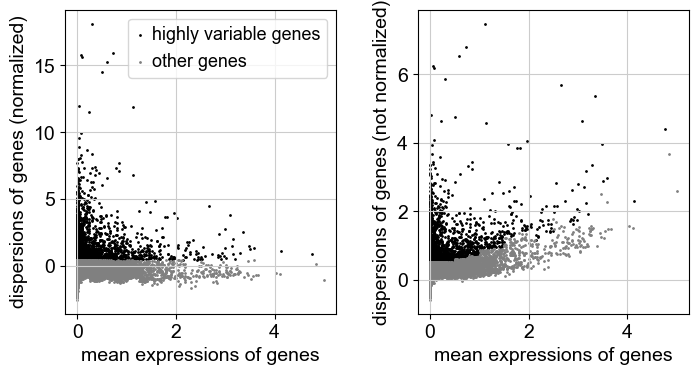

In [7]:
# FEATURE SELECTION

sc.pp.highly_variable_genes(adata, n_top_genes=3000)  # Keep the top 3000 most variable genes

sc.pl.highly_variable_genes(adata)

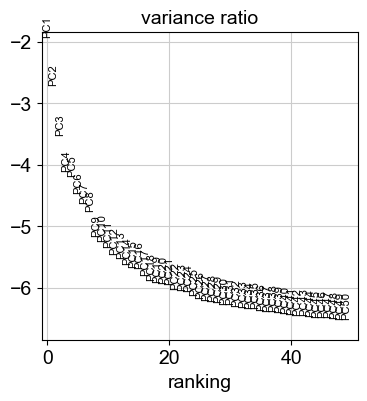

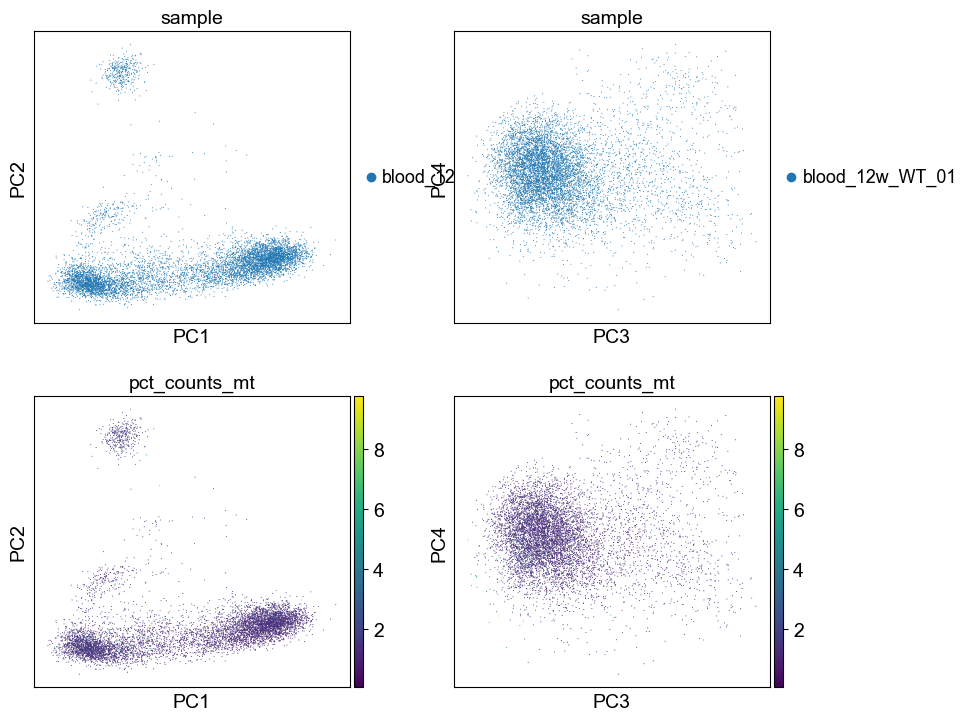

In [8]:
# PCA

sc.tl.pca(adata)

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
#the elbow is at pc3

sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

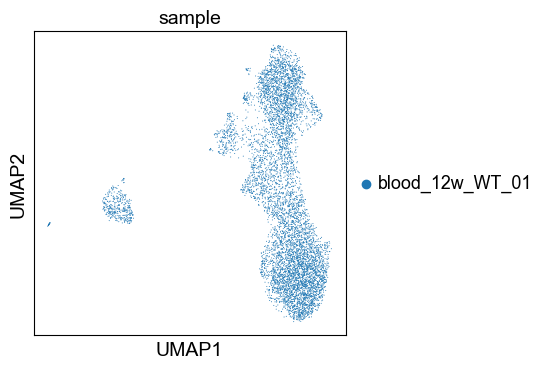

In [9]:
# UMAP

sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [10]:
adata.write("blood_12w_KO_01_processed.h5ad")

In [11]:
# CLUSTER

In [12]:
# MERGE and INTEGRATE datasets
# USING HARMONY

In [13]:
# CLUSTER - composition per sample? more of one type of monocyte in each state?

In [14]:
# DIFFERENTIAL EXPRESSION 